In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload
from icedef import test_case, simulator, metocean
from icedef import statoil_arcticnet_data as statoil_data

# OSCAR

In [2]:
ds = xr.open_dataset('/home/evankielley/Downloads/oscar_vel2015.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 481, longitude: 1201, time: 72, year: 72)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-06 ... 2015-12-26
  * year       (year) float32 2015.0 2015.0139 2015.0278 ... 2015.9722 2015.9861
  * depth      (depth) float32 15.0
  * latitude   (latitude) float64 80.0 79.67 79.33 79.0 ... -79.33 -79.67 -80.0
  * longitude  (longitude) float64 20.0 20.33 20.67 21.0 ... 419.3 419.7 420.0
Data variables:
    u          (time, depth, latitude, longitude) float64 ...
    v          (time, depth, latitude, longitude) float64 ...
    um         (time, depth, latitude, longitude) float64 ...
    vm         (time, depth, latitude, longitude) float64 ...
Attributes:
    VARIABLE:       Ocean Surface Currents
    DATATYPE:       1/72 YEAR Interval
    DATASUBTYPE:    unfiltered
    GEORANGE:       20 to 420 -80 to 80
    PERIOD:         Jan.01,2015 to Dec.26,2015
    year:           2015
    description:    OSCAR Third Degree Se

In [4]:
ds.variables['um']

<xarray.Variable (time: 72, depth: 1, latitude: 481, longitude: 1201)>
[41593032 values with dtype=float64]
Attributes:
    units:      meter/sec
    long_name:  Ocean Surface Zonal Currents Maximum Mask

In [5]:
ds.attrs['note1']

'Maximum Mask velocity is the geostrophic component at all points + any concurrent Ekman and buoyancy components'

In [6]:
ds.attrs['note2']

'Longitude extends from 20 E to 420 E to avoid a break in major ocean basins. Data repeats in overlap region.'

# Iceberg Track Bounding Box for Fraser

In [7]:
beacon_metadata_url = 'http://icedef.munroelab.ca/data/StatoilArcticNet/drift_tracks/MunroeMetadata.csv'
beacon_metadata = pd.read_csv(beacon_metadata_url)

def get_beacon_df(beacon_id):
    
    url = f'http://icedef.munroelab.ca/data/StatoilArcticNet/drift_tracks/0{beacon_id}_2015.csv'
    
    return pd.read_csv(url, parse_dates=['DataDate_UTC'])

beacon_id_list = list(beacon_metadata['BeaconID'].values)

beacon_df_dict = {}
beacon_ds_dict = {}

for beacon_id in beacon_id_list:
    
    beacon_df_dict[f'{beacon_id}'] = get_beacon_df(beacon_id)
    beacon_ds_dict[f'{beacon_id}'] = get_beacon_df(beacon_id).set_index('DataDate_UTC').to_xarray()



In [8]:
min_lat = 1000
min_lon = 1000
max_lat = -1000
max_lon = -1000
min_time = np.datetime64('2018-01-01')
max_time = np.datetime64('1900-01-01')

for key, ds in beacon_ds_dict.items():
    
    if float(min(ds['Latitude'].values)) < min_lat:
        min_lat = float(min(ds['Latitude'].values))
    
    if float(min(ds['Longitude'].values)) < min_lon:
        min_lon = float(min(ds['Longitude'].values))
        
    if float(max(ds['Latitude'].values)) > max_lat:
        max_lat = float(max(ds['Latitude'].values))
    
    if float(max(ds['Longitude'].values)) > max_lon:
        max_lon = float(max(ds['Longitude'].values))
        
    if max(ds['DataDate_UTC'].values) > max_time:
        max_time = max(ds['DataDate_UTC'].values)
    
    if min(ds['DataDate_UTC'].values) < min_time:
        min_time = max(ds['DataDate_UTC'].values)

min_lat, min_lon, max_lat, max_lon, min_time, max_time

(49.20878,
 -54.014759999999995,
 52.69404,
 -47.81201,
 numpy.datetime64('2015-04-23T19:57:39.000000000'),
 numpy.datetime64('2015-06-13T09:33:42.000000000'))

In [52]:
beacon_ds_dict.keys()

dict_keys(['204980', '505190', '906790', '907780'])

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


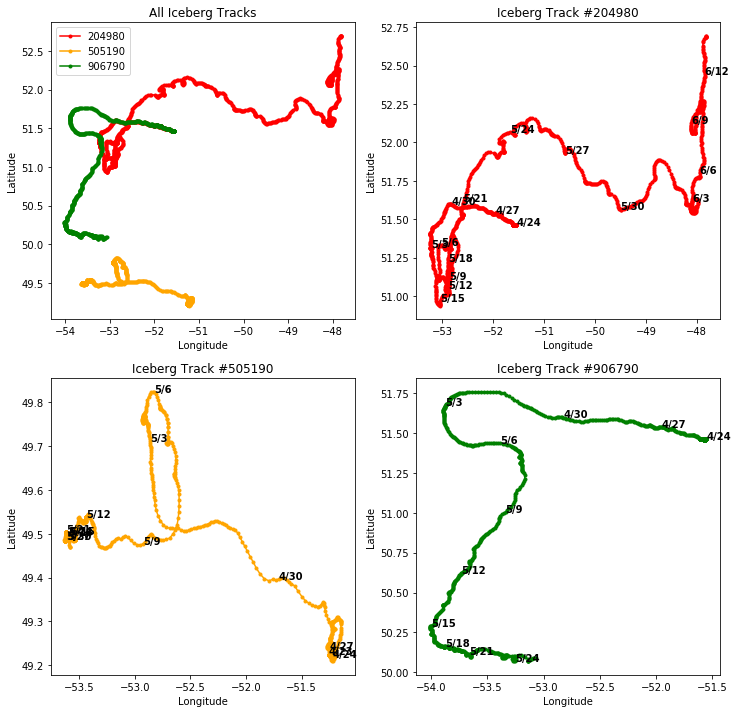

In [66]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
colors = ['red', 'orange', 'green', 'blue']
i = 2
for key, ds in beacon_ds_dict.items():
    if not key == '907780':
        dt64s = ds['DataDate_UTC'].values
        plt.subplot(2, 2, 1)
        plt.plot(ds['Longitude'], ds['Latitude'], '.-', color=colors[i-2], label=key)
        date = pd.to_datetime(dt64s[0])
        plt.annotate(f'{date.month}/{date.day}', 
             (ds['Longitude'].values[0], ds['Latitude'].values[0]),
            fontweight='bold')
        date = pd.to_datetime(dt64s[-1])
        plt.annotate(f'{date.month}/{date.day}', 
             (ds['Longitude'].values[-1], ds['Latitude'].values[-1]),
            fontweight='bold')
        plt.title('All Iceberg Tracks')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        
        plt.subplot(2, 2, i)
        plt.plot(ds['Longitude'], ds['Latitude'], '.-', color=colors[i-2])

        plt.annotate(f'{date.month}/{date.day}', 
                     (ds['Longitude'].values[0], ds['Latitude'].values[0]),
                    fontweight='bold')

        for j in range(1, len(dt64s)):
            previous_date = pd.to_datetime(dt64s[j-1])
            date = pd.to_datetime(dt64s[j])
            if date.day != previous_date.day and np.mod(date.day, 3) == 0:
                plt.annotate(f'{date.month}/{date.day}', 
                             (ds['Longitude'].values[j], ds['Latitude'].values[j]),
                            fontweight='bold')
        plt.title(f'Iceberg Track #{key}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        i +=1  
fig = plt.gcf()
fig.savefig('beacon_tracks.png')
plt.show()

# Simulating

In [11]:
reload(simulator)

<module 'icedef.simulator' from '/home/evankielley/IceDEF/icedef/simulator.py'>

In [12]:
tc = test_case.TestCase(index_range=(867, 914))
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats
start_location = (tc.start_latitude, tc.start_longitude)
time_frame = (tc.start_time, tc.end_time)
start_velocity = tc.start_velocity

In [13]:
sim = simulator.Simulator()

sim.run_simulation(start_location, time_frame, store_results_as='ECMWF')
sim.ocean_model = metocean.HYCOMOcean
sim.run_simulation(start_location, time_frame, store_results_as='HYCOM')

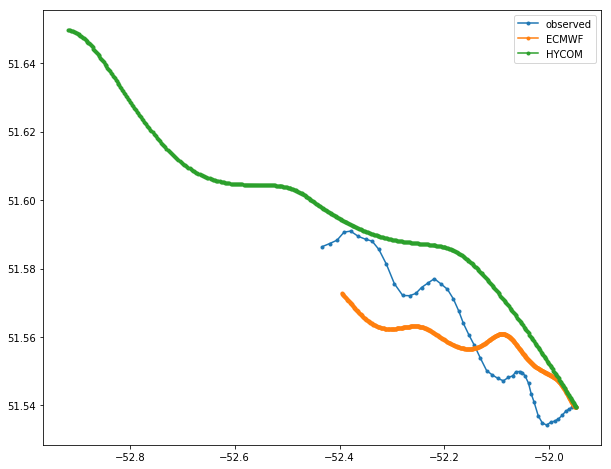

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(ref_lons, ref_lats, '.-', label='observed')
plt.plot(sim.results['ECMWF']['longitude'], sim.results['ECMWF']['latitude'], '.-', label='ECMWF')
plt.plot(sim.results['HYCOM']['longitude'], sim.results['HYCOM']['latitude'], '.-', label='HYCOM')
plt.legend()
plt.show()

# Optimizing

In [15]:
keys = ['Ca', 'Cw']
x0 = 1.5, 1.5
bounds = (0, 10), (0, 10)
reference_vectors = ref_lats, ref_lons
optimization_result = simulator.run_optimization(sim, keys, x0, bounds, reference_vectors, 
                                                 start_location, time_frame)

In [16]:
optimization_result

      fun: 0.22653190347410926
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0023842 , -0.00037322])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 135
      nit: 2
   status: 2
  success: False
        x: array([0.64428207, 3.54900247])

In [17]:
sim.run_simulation(start_location, time_frame, 
                   Ca=optimization_result.x[0], Cw=optimization_result.x[1], 
                   store_results_as='HYCOM_optimized')

In [18]:
sim.run_simulation(start_location, time_frame, 
                   Ca=6, Cw=8, 
                   store_results_as='HYCOM_handtuned')

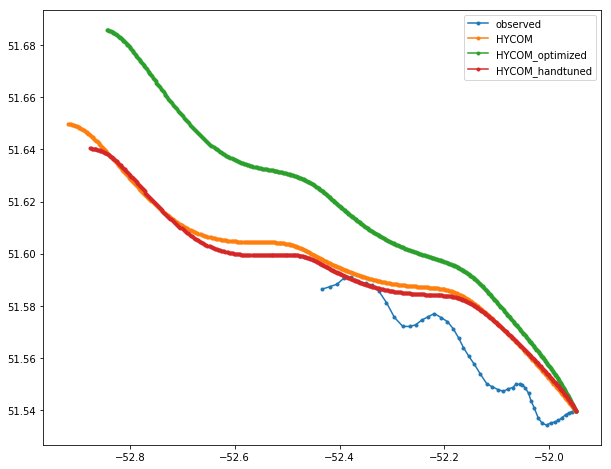

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(ref_lons, ref_lats, '.-', label='observed')
plt.plot(sim.results['HYCOM']['longitude'], sim.results['HYCOM']['latitude'], '.-', label='HYCOM')
plt.plot(sim.results['HYCOM_optimized']['longitude'], sim.results['HYCOM_optimized']['latitude'], '.-', label='HYCOM_optimized')
plt.plot(sim.results['HYCOM_handtuned']['longitude'], sim.results['HYCOM_handtuned']['latitude'], '.-', label='HYCOM_handtuned')

plt.legend()
plt.show()